# Problem Statement:

The objective is to automate the loan eligibility process based on customer details. We have a dataset that includes information such as Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and more.



### Student: Corey He
### Student ID: 217253527

## Step1:
**load the loan.csv file from data folder as a pandas dataframe and visualize the first 5 rows of the dataframe.**

In [245]:
import pandas as pd

# you must complete this function to load the data
def load_data(address):
    df = pd.read_csv(address)
    return df

df = load_data('data/loan.csv')
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Step2: 
**Explore the data**

In [249]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Complete the following function to create a histogram for each of the numerical features.

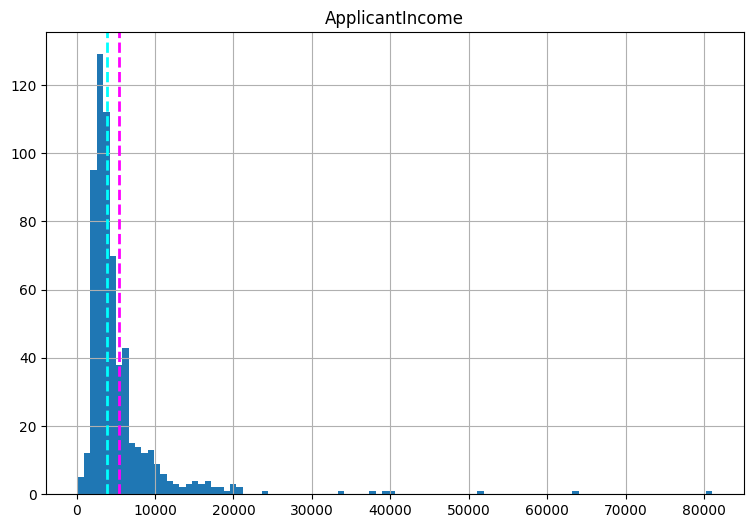

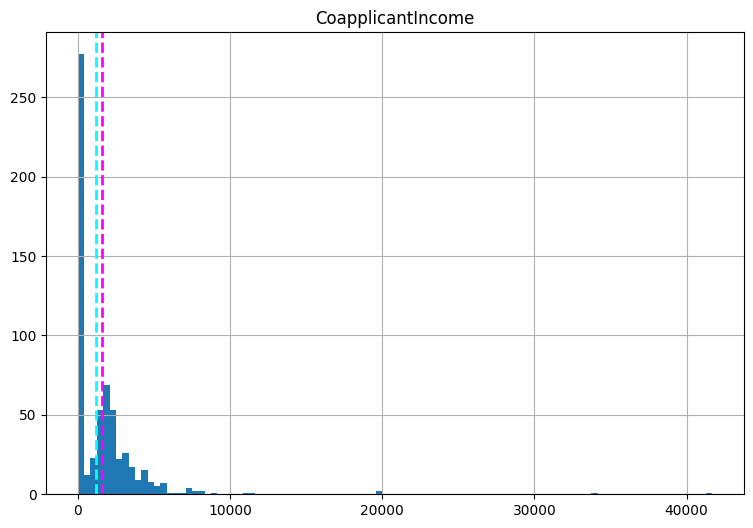

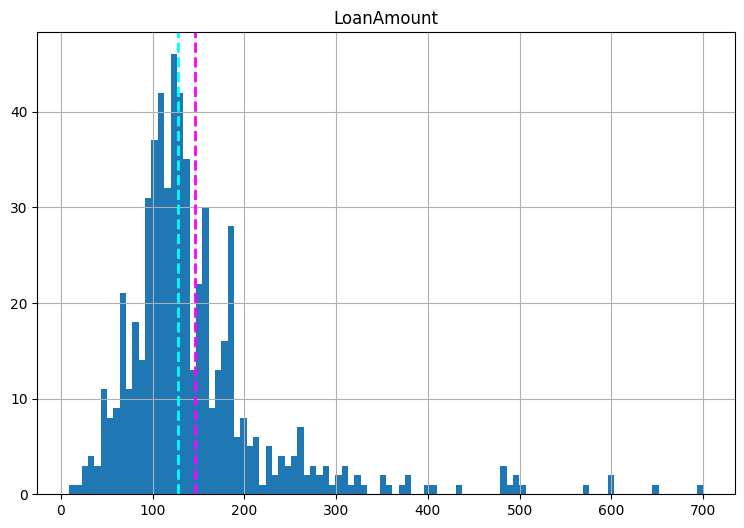

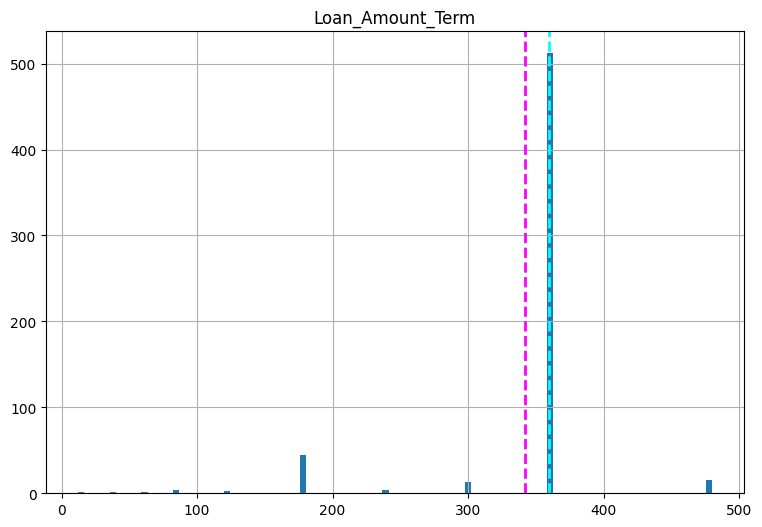

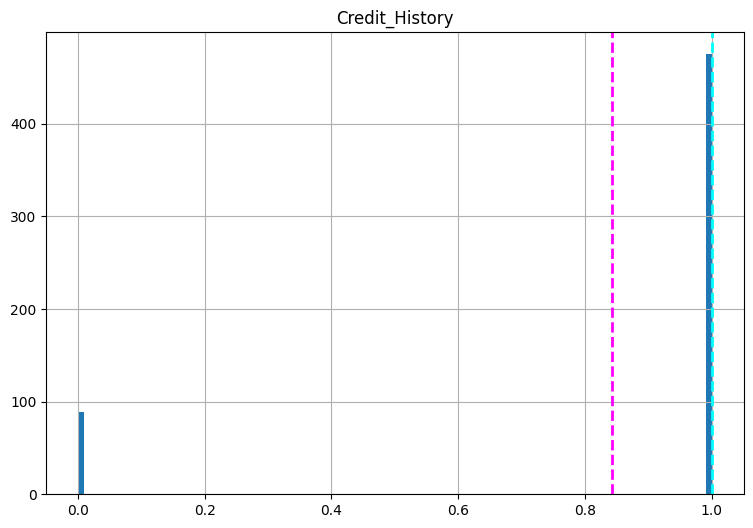

In [250]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_histogram(df, col):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)

numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in numeric_features:
    plot_histogram(df, col)
plt.show()

Now complete the following function to compare the distribution of samples per label for each feature by plotting a boxplot.

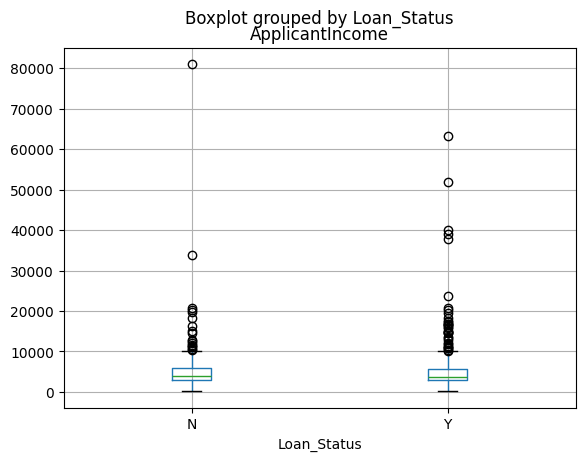

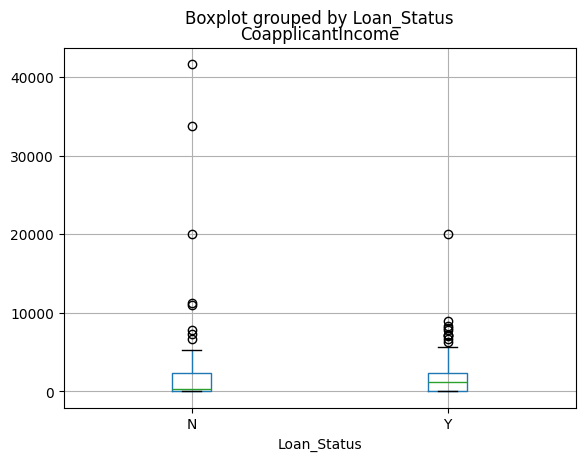

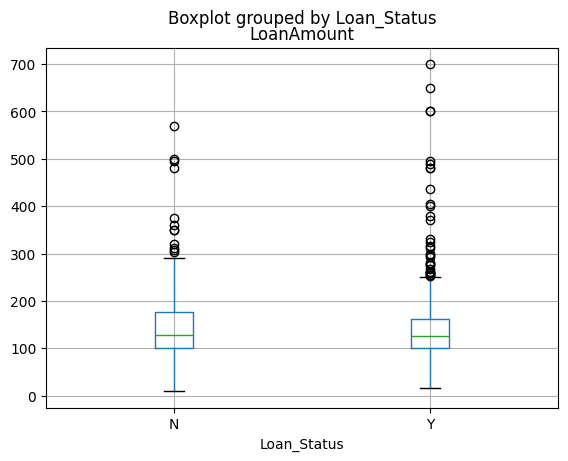

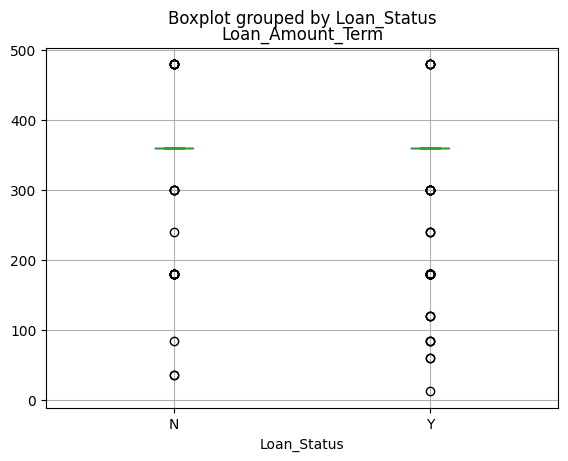

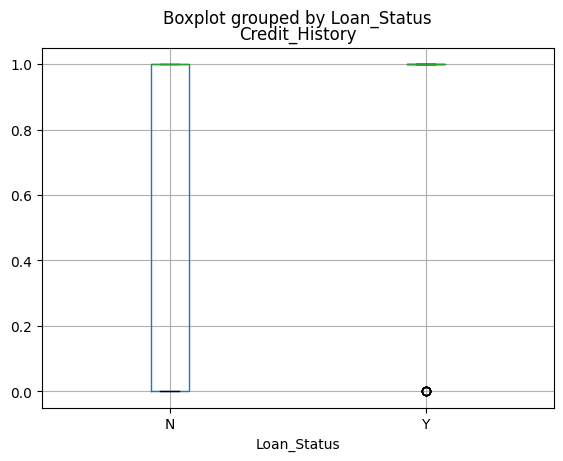

In [251]:
def plot_boxplot(df, col):
    df.boxplot(column=col, by='Loan_Status')
    plt.title(col)

for col in numeric_features:
    plot_boxplot(df, col)

Now Complete the function below, to plot a bar chart showing the count of samples of discrete features.

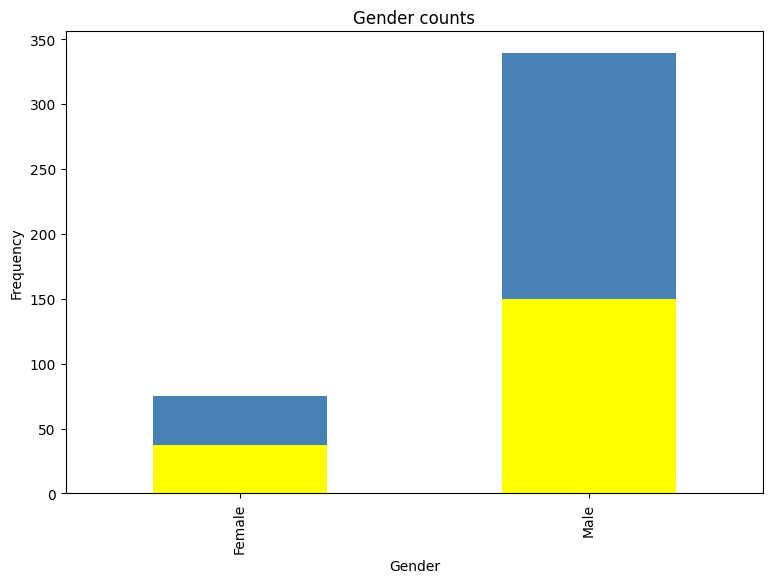

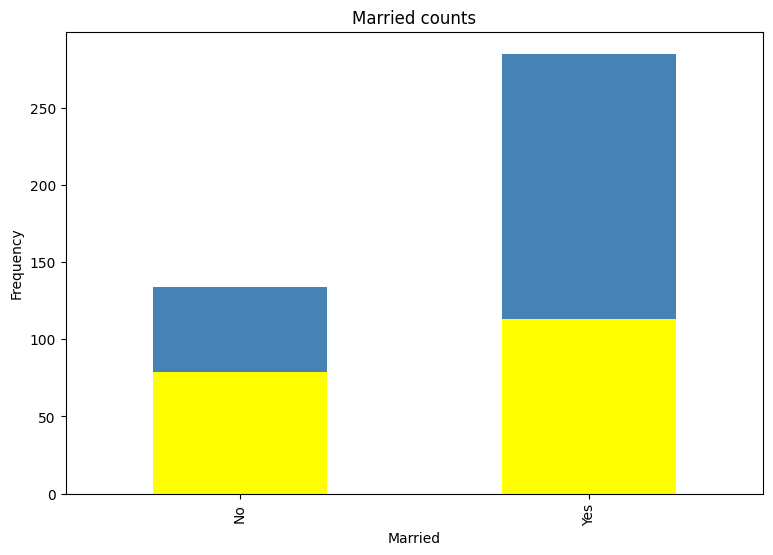

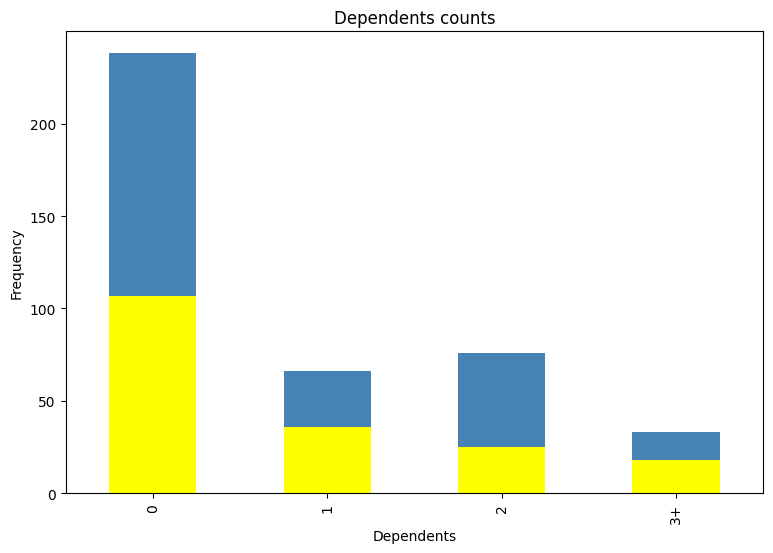

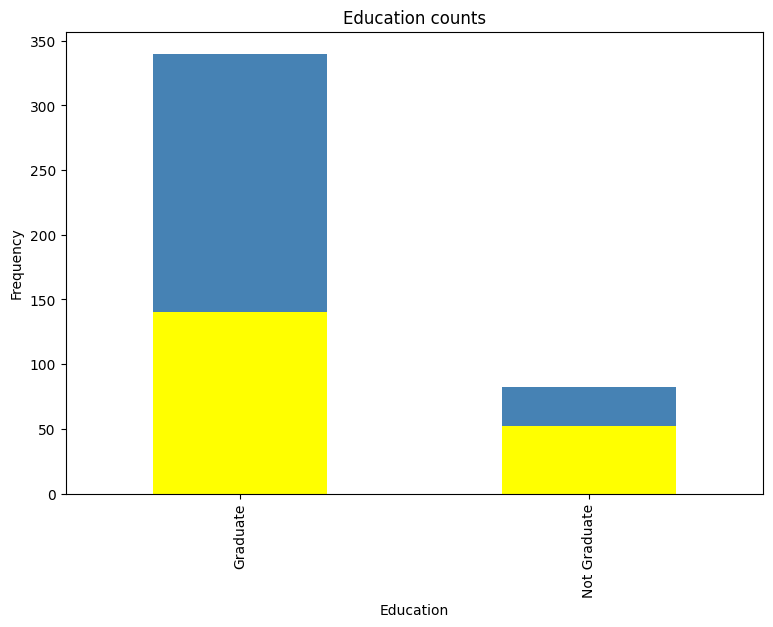

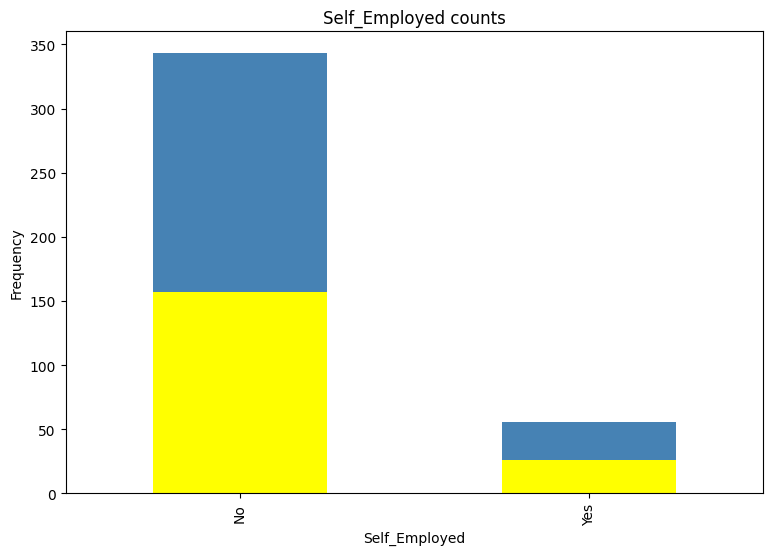

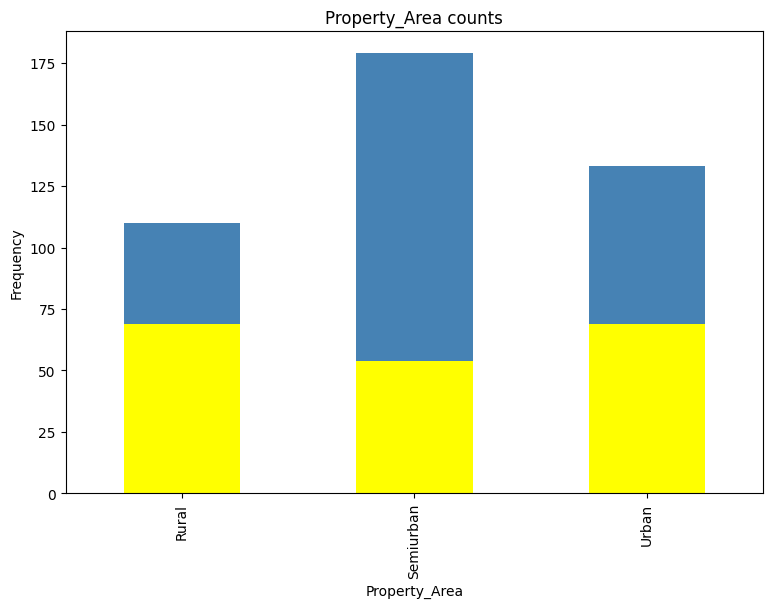

In [252]:
def plot_barchart(df, col):
#  
    approved_counts=df[col][df['Loan_Status']=="Y"].groupby(df[col]).count()
    denied_counts=df[col][df['Loan_Status']=="N"].groupby(df[col]).count()
    

    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    approved_counts.plot.bar(ax = ax, color='steelblue')
    denied_counts.plot.bar(ax = ax, color='yellow')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")

categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for col in categorical_features:
    plot_barchart(df, col)

---
**Question:**
- **Can you share any interesting insights or observations you made during this visualization process? Consider aspects such as feature distributions, class separation, potential outliers, or any other patterns you noticed. How might these insights inform your approach to modeling or preprocessing in the next steps?"**

1. First, notably there is a great imbalance in distribution of the categorial features. Gender, Married, Dependents, Education, and Self_Employed are heavily skewed towards one direction. Only Property_Area is somewhat more evenly distributed. These uneven distributions will likely cause the model to be biased in its classification. For example, Self_Employed has only two possible responses, yes or no. However, for "yes", there is only 70-ish occurrences while for "no" there is almost 350. Out of those 70~ occurences, the class is split half and half. But out of the 350~ occurences, it is split closer 60-40, with 60 being the yes for the class loan_status. The model we train on this data may say that one must not be self-employed to receive a loan, which is not true.

    Something similar can be said for the Dependents feature. Due to the imbalance between occurrences of no dependents and having dependents, the model may believe that in order for one to get their loan approved, they must not have any dependents/children. This is likely not desirable as many individuals have children.

2. Second, for the numerical features, from the boxplots, outliers can be directly observed. For ApplicantIncome, CoapplicantIncome and Loan_Amount, the outliers are outside of the Q3 quantile. They are quite numerous and will likely lower the accuracy of the model.

    These insights will lead me to change up my approach for modeling and preprocessing. The outliers will need to be preprocessed, likely removed from the training and testing datasets while the imbalance in features and class may require some hyperparameter tuning. However, that will likely only happen after the initial models are made.

## Step3:
**Handling missing values**

In [255]:
def count_the_missing_values_of_each_column(df):
    missing_values_series = df.isnull().sum()
    return missing_values_series
    
missing_values_series = count_the_missing_values_of_each_column(df)
print(missing_values_series)

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


**Complete the following functions to fill the missing values based on KNN**

**Part1**:

Since KNN could only handle numercal values, we should first transform the categorical variables into numerical ones:

In [256]:
from sklearn.preprocessing import OrdinalEncoder

def generate_the_df_with_categorical_features_encoded(df, cols):
    ordinal_encoder = OrdinalEncoder()
    df_encoded = pd.DataFrame(ordinal_encoder.fit_transform(df[cols].values), columns=cols)
    df[cols] = df_encoded
    return df
    
categorical_features_with_missing_valuse = ['Gender', 'Married', 'Dependents', 'Self_Employed']

df = generate_the_df_with_categorical_features_encoded(df, categorical_features_with_missing_valuse)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,Graduate,0.0,5849,0.0,NaN,360.0,1.0,Urban,Y
1,1.0,1.0,1.0,Graduate,0.0,4583,1508.0,128.0,360.0,1.0,Rural,N
2,1.0,1.0,0.0,Graduate,1.0,3000,0.0,66.0,360.0,1.0,Urban,Y
3,1.0,1.0,0.0,Not Graduate,0.0,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,1.0,0.0,0.0,Graduate,0.0,6000,0.0,141.0,360.0,1.0,Urban,Y


**part2**: 

Now that we've transformed the data lets use KNN to impute the missing values:

In [259]:
from sklearn.impute import KNNImputer
import numpy as np

def impute_the_Gender_missing_values(df):  
    knn_imputer = KNNImputer()
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = pd.DataFrame(knn_imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)
    return df

df = impute_the_Gender_missing_values(df)

In [260]:
missing_values_series = count_the_missing_values_of_each_column(df)
print(missing_values_series)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [261]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,Graduate,0.0,5849.0,0.0,147.8,360.0,1.0,Urban,Y
1,1.0,1.0,1.0,Graduate,0.0,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,1.0,1.0,0.0,Graduate,1.0,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,1.0,1.0,0.0,Not Graduate,0.0,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,1.0,0.0,0.0,Graduate,0.0,6000.0,0.0,141.0,360.0,1.0,Urban,Y


## Step4:

**Preparing data for prediction**

Now complete the following function to separate features from labels and then split the training set from testing set with test_size being 30% of the data and set the random_state to be zero

In [262]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def separate_features_from_label_and_split_the_data(df, features, label, test_size=0.3, random_state=0):
    # Encode the target variable using LabelEncoder
    label_encoder = LabelEncoder()
    df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])
    # Separate features from label
    X, y = df[features], df[label]
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    return X_train, X_test, y_train, y_test
    
features = ['Gender','Married','Dependents','Education','Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
            'Property_Area']
label = 'Loan_Status'

X_train, X_test, y_train, y_test = separate_features_from_label_and_split_the_data(df, features, label, test_size=0.3, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))
X_train.head()

Training cases: 429
Test cases: 185


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
351,1.0,0.0,0.0,Graduate,0.0,8750.0,4167.0,308.0,360.0,1.0,Rural
593,1.0,1.0,0.0,Graduate,0.0,3859.0,3300.0,142.0,180.0,1.0,Rural
320,1.0,1.0,0.0,Graduate,0.0,2400.0,2167.0,115.0,360.0,1.0,Semiurban
186,1.0,1.0,1.0,Graduate,1.0,2178.0,0.0,66.0,300.0,0.0,Rural
557,1.0,1.0,3.0,Graduate,1.0,10139.0,0.0,260.0,360.0,1.0,Semiurban


## Step5:

**Lets begin by training a KNN model**

First complete the following function to generate a pipeline:

In [263]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

def generate_knn_pipeline(df, ordinal_categorical_feature, onehot_categorical_feature, numerical_features):
    # Define categorical and numerical features
    c1_idx = [df.columns.get_loc(item) for item in ordinal_categorical_feature]
    c2_idx = [df.columns.get_loc(item) for item in onehot_categorical_feature]
    n_idx = [df.columns.get_loc(item) for item in numerical_features]
    
    # Create transformers for numerical and categorical features
    ordinal_categorical_transformer = OrdinalEncoder(categories=[['Graduate','Not Graduate']],handle_unknown="error")
    
    onehot_categorical_transformer = OneHotEncoder(categories=[['Urban','Semiurban','Rural']],handle_unknown="error")

    numerical_transformer = StandardScaler()
    
    # Apply transformers to features using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat1', ordinal_categorical_transformer, c1_idx),
            ('cat2', onehot_categorical_transformer, c2_idx),
            ('num', numerical_transformer, n_idx),
        ])
    
    # Define the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=3)
    
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', knn_model)
    ])

    return pipeline

ordinal_categorical_feature = ['Education']
onehot_categorical_feature = ['Property_Area']
numerical_features = df.columns.difference(ordinal_categorical_feature + onehot_categorical_feature + ['Loan_Status'])

pipeline = generate_knn_pipeline(df, ordinal_categorical_feature, onehot_categorical_feature, numerical_features)

---
**Question:**
- **We have employed both the Ordinal encoder and the OneHot encoder in this exercise for encoding different categorical features. Can you provide a rationale for the choice of encoder for each feature? In other words, why did we choose to use the Ordinal encoder for certain features and the OneHot encoder for others? What considerations or characteristics of the features have influenced our decision in selecting the appropriate encoder for each case?**

We chose the Ordinal Encoder for Education because Education categorical values has a rank to them. While we chose OneHot Encoder for Property_Area because Property_Area's categorical values do not have a rank to them.
<br>
When the feature's values have a rank to them, like Graduate or Not Graduate, we use the Ordinal encoder to keep that characteristics. When the feature's values don't have a rank to them, like urban, semi-urban and rural, we use the OneHot encoder since there is no rank/order relationship between them.
<br>
It's these characteristics that decide which encoder is appropriate for each case.

Now complete the following snippet to make prediction and evaluate the results:

In [264]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get predictions from test data
predictions = pipeline.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Confusion Matrix:
 [[ 26  25]
 [ 17 117]] 

Accuracy: 0.772972972972973
Overall Precision: 0.823943661971831
Overall Recall: 0.8731343283582089


## Step6: 
**Lets make the pipeline comprehensive and include the missing value imputation in the pipeline**

In [265]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

df = load_data('data/loan.csv')

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])

X_train, X_test, y_train, y_test = separate_features_from_label_and_split_the_data(df, features, label, test_size=0.3, random_state=0)

# Define categorical and numerical features
ordinal_categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed']
c1_idx = [df.columns.get_loc(item) for item in ordinal_categorical_features]
onehot_categorical_features = ['Property_Area']
c2_idx = [df.columns.get_loc(item) for item in onehot_categorical_features]
numerical_features = df.columns.difference(ordinal_categorical_features + onehot_categorical_features + ['Loan_Status'])
n_idx = [df.columns.get_loc(item) for item in numerical_features]

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='error'))
])

onehot_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

column_imputer = Pipeline(steps=[
    ('imputer0', KNNImputer())
])

# Apply transformers to features using ColumnTransformer
feature_transformer = ColumnTransformer(
    transformers=[
        ('cat1', ordinal_categorical_transformer, c1_idx),
        ('cat2', onehot_categorical_transformer, c2_idx),
        ('num', numerical_transformer, n_idx),
    ])

missing_value_imputer = ColumnTransformer(
    transformers=[
        ('imputer', column_imputer, c1_idx + c2_idx + n_idx)
    ])

# Define the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors

# Create the pipeline
pipeline = Pipeline(steps=[('transformer',feature_transformer),('imputer',missing_value_imputer),('classifier',knn_model)])

from sklearn import set_config
set_config(display="diagram")
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('cat2',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [10]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [5, 6, 9, 7, 8])])),
                ('imputer',
                 ColumnTransformer(transformers=[('imputer',
                                                  Pipeline(steps=[('imputer0',
                                                                   KNNImputer())]),
                                                  [0, 1, 2, 3, 4, 10, 5, 6, 9,
                                                   7, 8])])),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [266]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get predictions from test data
predictions = pipeline.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Confusion Matrix:
 [[ 25  26]
 [ 15 119]] 

Accuracy: 0.7783783783783784
Overall Precision: 0.8206896551724138
Overall Recall: 0.8880597014925373


## Step7: 
**Lets try other classifiers in the pipeline**

Complete the following snippet to replace the KNN model with Naive Bayse model

In [267]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
pipeline.set_params(classifier=GaussianNB())

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('cat2',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [10]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [5, 6, 9, 7, 8])])),
                ('imputer',
                 ColumnTransformer(transformers=[('imputer',
                                                  Pipeline(steps=[('imputer0',
                                                                   KNNImputer())]),
                                                  [0, 1, 2, 3, 4, 10, 5, 6, 9,
                                                   7, 8])])),
                ('classifier', GaussianNB())])

In [268]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get predictions from test data
predictions = pipeline.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Confusion Matrix:
 [[ 22  29]
 [  5 129]] 

Accuracy: 0.8162162162162162
Overall Precision: 0.8164556962025317
Overall Recall: 0.9626865671641791


Complete the following snippet to replace the Naive Bayse model with SVM

In [269]:
from sklearn.svm import SVC
svc = SVC(kernel='linear', gamma=10)
pipeline.set_params(classifier=svc)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('cat2',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [10]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [5, 6, 9, 7, 8])])),
                ('imputer',
                 ColumnTransformer(transformers=[('imputer',
                                                  Pipeline(steps=[('imputer0',
                                                                   KNNImputer())]),
                                                  [0, 1, 2, 3, 4, 10, 5, 6, 9,
                                                   7, 8])])),
                ('classifier', SVC(gamma=10, kernel='linear'))])

In [270]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get predictions from test data
predictions = pipeline.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Confusion Matrix:
 [[ 21  30]
 [  2 132]] 

Accuracy: 0.827027027027027
Overall Precision: 0.8148148148148148
Overall Recall: 0.9850746268656716


---
**Question:**
- **Among the various classification models implemented in this exercise, which one demonstrates superior performance in terms of the evaluation metrics such as accuracy, precision, and recall? Provide a detailed interpretation of the metrics and explain why you consider one model to be more effective than others in addressing the classification task. Consider aspects such as the balance between precision and recall, and any specific characteristics of the dataset that might influence your choice of the most effective model.**

### Our classification task is to determine the loan eligibility of individuals. It is a binary classification, with both results seemingly equal unless stated otherwise. Through the evaluation metrics, the SVM Model can be observed to have performed the best out of all three models. 

SVM <br>
Confusion Matrix: <br>
    21 30 <br>
    2 132 <br>
    <br>
Accuracy: 0.827 <br> 
Overall Precision: 0.814 <br>
Overall Recall: 0.985 <br>

1. The SVM Model's confusion matrix reports a 21 TP and a 132 TN out of a total of 185 test cases. This means that the SVM Model got 82.7% accuracy. But the SVM model underperforms compared to the other two models in terms of Precision. KNN Classifier has the highest Precision.

KNN Classifier <br>
Confusion Matrix: <br>
    25  26 <br>
    15 119 <br>
    
Accuracy: 0.778 <br>
Overall Precision: 0.820 <br>
Overall Recall: 0.888 <br>

2. KNN Classifier has more TP and less FP than the other two models, which makes it a more useful model in terms of safety for loan eligibility. However, it also has the highest amount of FN, which causes it to have a lower accuracy and recall. This means that if the bank were to use the KNN classifier to determine their customer's loan eligibility, more people would be ineligible for a loan by accident. Depending on the bank, this may be acceptable or unacceptable.

    If the bank is willing to accept higher risk, they may choose the Naive Bayes classifier which sits in between the SVM and the KNN Model in terms of performance.

NaiveBayes <br>
Confusion Matrix: <br>
22  2 <br>
5 1 <br>
Accuracy:0.816 <br>
Overall Precision: 0.816<br>
Overall Recall:0.962<br>

3. The Naive Bayes Model sits in between the two other models in terms of performance. With higher accuracy than KNN but slightly less than the SVM Model, and lower precision than KNN but more than the SVM MIn conclusionverall, the Naive Bayes Model is the balanced choice for the bank if they are willing to accept some risk in terms of loans.

<br>
4. All in all, the SVM Model is better at classifying individuals not eligible for a loan than the other models, while the other models are better at classifying individuals eligible for a loan. Despite that, the SVM Model is the better performing model as there will be more people who do not qualify for a loan than there will be people who do.


## Step 8:
**Considering the classification models covered in this lesson, implement a model to identify the single feature that provides the best separation for the classification task. Report the evaluation metrics of the model, including accuracy. Additionally, specify which feature is determined to be the most effective for classification.**

In [271]:
##Implement the model here!##
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion="gini",max_depth=4)
pipeline.set_params(classifier=dt)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat1',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('cat2',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [10]),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [5, 6, 9, 7, 8])])),
                ('imputer',
                 ColumnTransformer(transformers=[('imputer',
                                                  Pipeline(steps=[('imputer0',
                                                                   KNNImputer())]),
                                                  [0, 1, 2, 3, 4, 10, 5, 6, 9,
                                                   7, 8])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [272]:
pipeline.fit(X_train, y_train)


predictions = pipeline.predict(X_test)

cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Confusion Matrix:
 [[ 21  30]
 [  4 130]] 

Accuracy: 0.8162162162162162
Overall Precision: 0.8125
Overall Recall: 0.9701492537313433


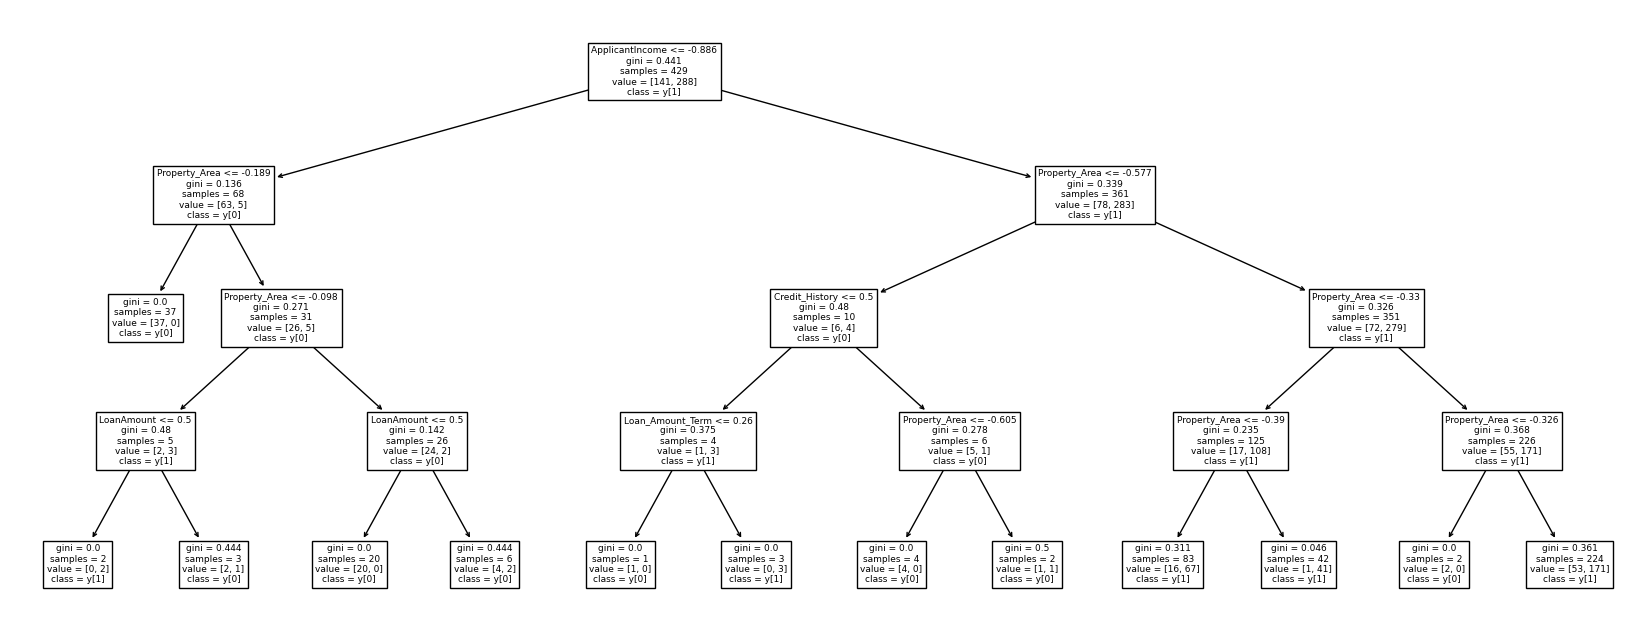

In [273]:
from sklearn import tree

fig = plt.subplots(figsize=(21, 8))
features=list(df.columns)
del features[-1]

tree.plot_tree(pipeline['classifier'],feature_names=features,class_names=True)
plt.show()

Feature 0:  Gender Score: 0.0
Feature 1:  Married Score: 0.0
Feature 2:  Dependents Score: 0.0
Feature 3:  Education Score: 0.0
Feature 4:  Self_Employed Score: 0.0
Feature 5:  ApplicantIncome Score: 0.7638583514471177
Feature 6:  CoapplicantIncome Score: 0.0
Feature 7:  LoanAmount Score: 0.027671878283751342
Feature 8:  Loan_Amount_Term Score: 0.019838295093130568
Feature 9:  Credit_History Score: 0.021601699101408838
Feature 10:  Property_Area Score: 0.16702977607459157


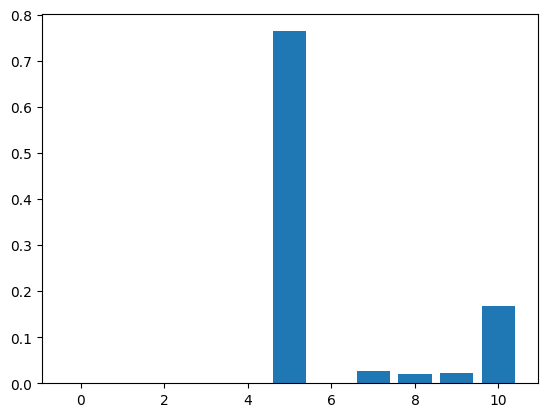

In [274]:
importance=pipeline['classifier'].feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature '+str(i)+":  "+features[i]+' Score: '+str(v))
# plot feature importance
plt.bar([x for x in range(len(features))], importance)
plt.show()

The model I implemented is a Decision Tree that splits based on Gini Index. 

Decision Tree Evaluation Metrics:
    Confusion Matrix: <br>
    21  30 <br>
    4 130 <br>
    
    Accuracy: 0.816
    Overall Precision: 0.8125
    Overall Recall: 0.97

My model has the same accuracy as the Naive Bayes Model, and slightly less Precision and slightly more Recall. It performs worse than the SVC and KNN Classifier.

The main feature that provides the best separation for the classification task is ApplicantIncome.

## Step 9:

**Revisit Step 2 in your analysis. Identify and implement one preprocessing technique covered in this course that has not been applied yet. Apply this technique to the best-performing model from Step 7 and report its impact on the evaluation metrics.**

*Hint: Think about data points that might significantly deviate from the overall pattern and explore techniques to identify and handle such instances. This step is often useful for improving model performance.*

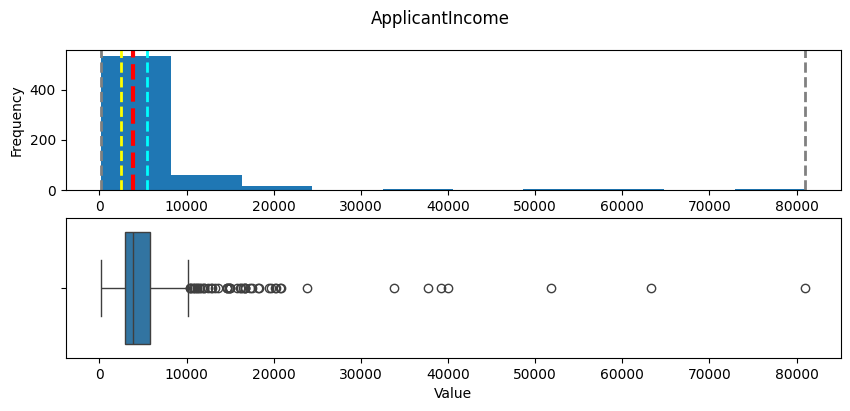

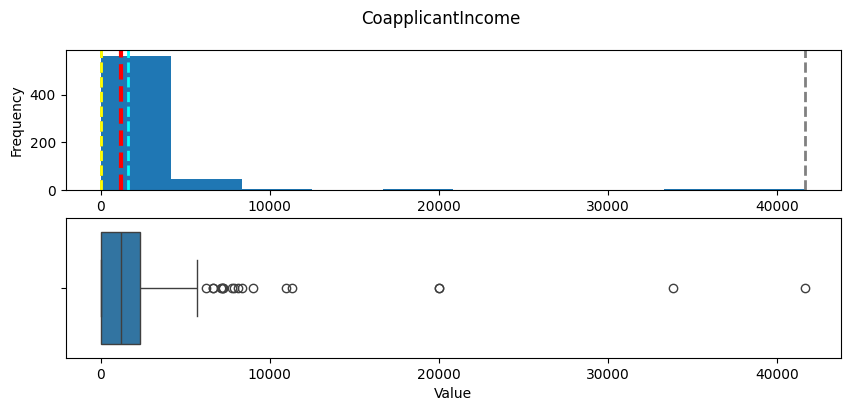

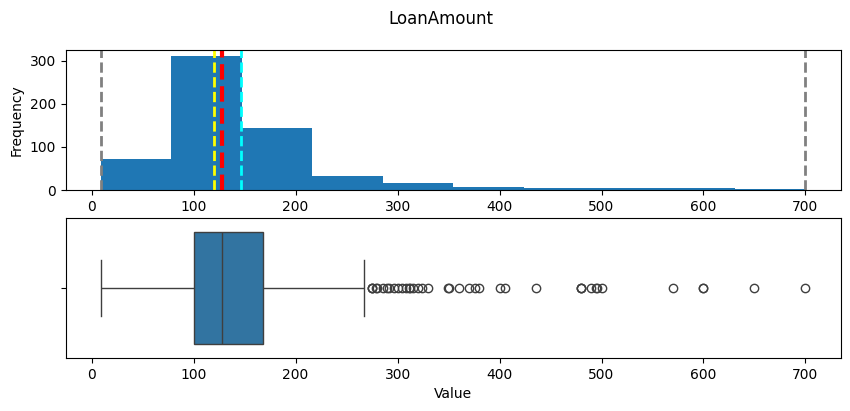

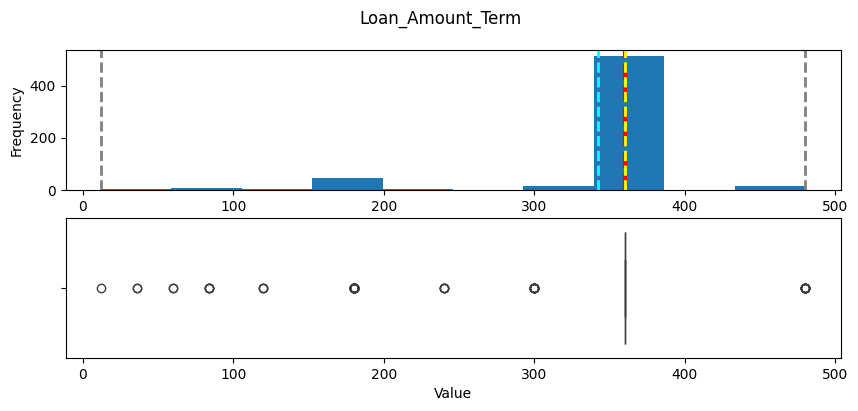

In [275]:
# Function to show summary stats and distribution for a column
def show_distribution(var_data):
    from matplotlib import pyplot as plt
    import seaborn as sns

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]
    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 3)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot
    sns.boxplot(var_data, orient='h',ax=ax[1])
    
    # ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

def plot_numeric_features(df):
    numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
    for col in numeric_features:
        show_distribution(df[col])


import pandas as pd
df = load_data('data/loan.csv')
plot_numeric_features(df)

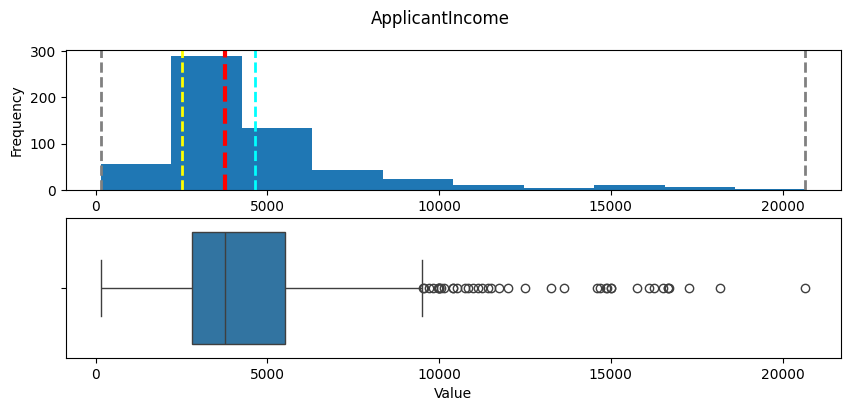

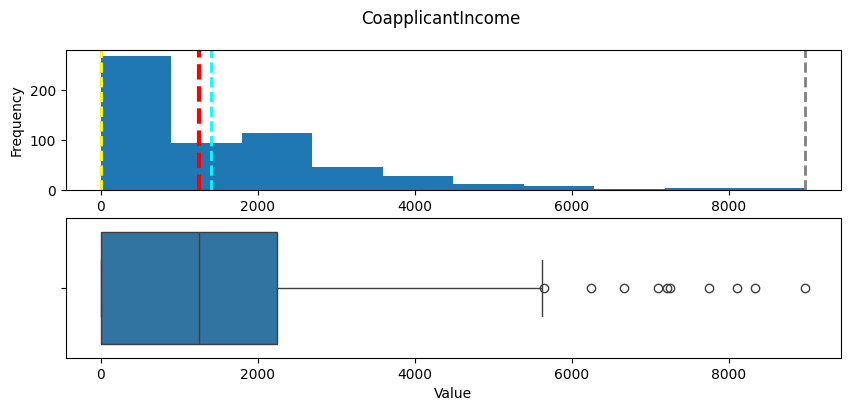

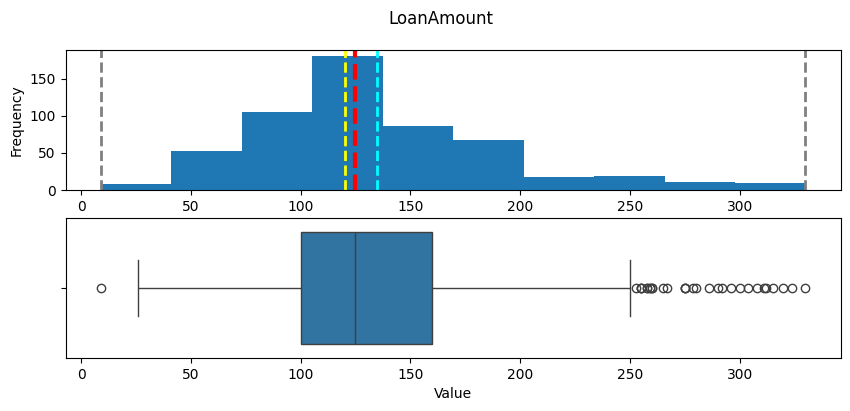

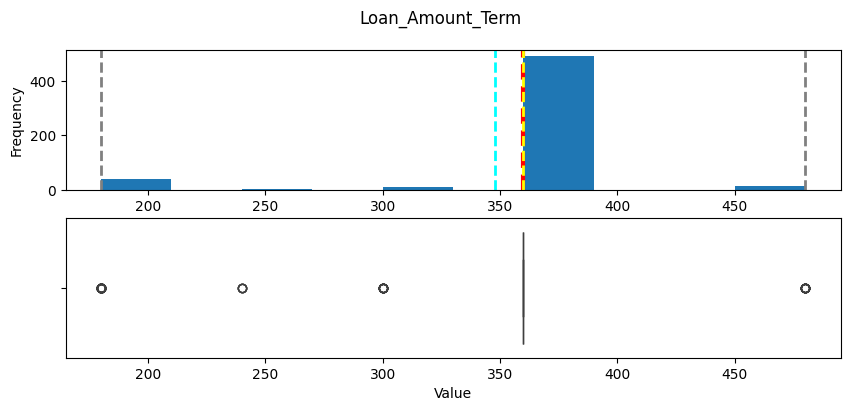

In [276]:
def outlier_removal(column):
    #As the numeric values present in the dataset are large, we need to account for it with a large z-score threshold.
    #The model actually gets worse the lower the z-score threshold.
    outlier_threshold = 3
    removed_outliers =(((df[column]-df[column].mean()).abs()>=(df[column].std()*outlier_threshold)))
    z_score_no_outlier_df = df[~removed_outliers]
    return z_score_no_outlier_df


df = load_data('data/loan.csv')
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
for x in numeric_features:
    df=outlier_removal(x)
plot_numeric_features(df)

In [277]:
# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])

X_train, X_test, y_train, y_test = separate_features_from_label_and_split_the_data(df, features, label, test_size=0.3, random_state=0)
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

pipeline = Pipeline(steps=[('transformer',feature_transformer),('imputer',missing_value_imputer),('classifier',svc)])
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get predictions from test data
predictions = pipeline.predict(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test,predictions)
print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test,predictions))
print("Overall Precision:", precision_score(y_test,predictions))
print("Overall Recall:", recall_score(y_test,predictions))

Training cases: 402
Test cases: 173
Confusion Matrix:
 [[ 27  23]
 [  3 120]] 

Accuracy: 0.8497109826589595
Overall Precision: 0.8391608391608392
Overall Recall: 0.975609756097561


---

**Note:** The dataset used in this exercise has been adapted from the challenge hosted at [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/). As a next step, consider exploring a variety of machine learning models and experimenting with different hyperparameters for each model. Strive to enhance the evaluation metrics, fine-tune your models and visualize the predictions by adapting dimentionality reduction methods like PCA. Additionally, you are encouraged to submit your predictions to the mentioned challenge for a more comprehensive comparison.

For further professional development, consider documenting your work in this Jupyter notebook and upload it to your GitHub account. This practice not only showcases your skills but also serves as a valuable addition to your resume.

Wishing you the best of luck in your endeavors!

---
